In [94]:
%matplotlib inline
from pathlib import Path
import cartopy.crs as ccrs
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy import stats
import statsmodels.api as sm
import datetime 
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import math
import statistics

In [95]:
file=Path(r"D:\Datasets\XTRACK\ESACCI-SEALEVEL-L3-SLA-N_INDIAN-MERGED-20200113-JA-053-fv01.1.nc")
ds=xr.open_dataset(file,decode_times=False)

In [104]:
def select_point(ds,point):
    ''' select a point in a track and return a dict with needed parameters'''
    #ref=pd.Timestamp(1950,1,1)
    output={}
    print(f"extract point #{point} on track {ds.pass_number}")
    output["dist"]=ds.dist_to_coast_gshhs[point].values/1000.
    output['pt']=point
    output["location"]=[ds.lon[point].values,ds.lat[point].values]
    #time = pd.to_datetime(ds.time[point,:], unit='D', origin=ref)
    time = ds.time[point,:]
    sla  = ds.sla[point,:]
    output["ts"]=pd.DataFrame(index=time,data={ds['sla'].attrs['long_name']:sla})
    output["valid"] = (1-(output['ts'].isna().sum().values[0] / len(output['ts'])))*100.
    output["trend"] = trend_ols(sla.values,ds.time[point,:].values)
    #output['trend_rate']=output["trend"]*1000*365
    output['flagged']=sigma_mask(output['ts'])
    return output

def sigma_mask(df,n=2):
    '''''''removing outliers'''
    sigma = df.std()
    mask = (df >- n*sigma) & (df < n*sigma)
    df_masked=df[mask.values]
    return df_masked

def flagged_trend(ds,point):
    
    time = ds.time[point,:]
    sla  = ds.sla[point,:]
    df=pd.DataFrame(index=time,data={ds['sla'].attrs['long_name']:sla})
    df_masked=sigma_mask(df,n=2)
    slope=trend_ols(df_masked.values,df_masked.index.values)
    print ('trend rate is :',(trend_rate),'mm/yr' )


def plot_point(ds,point):
    '''ploting points without outliers'''
    time = ds.time[point,:]
    sla  = ds.sla[point,:]
    df=pd.DataFrame(index=time,data={ds['sla'].attrs['long_name']:sla})
    df_masked=sigma_mask(df,n=2)
    ax=df.plot(marker='o',linestyle='',color='red')
    df_masked.plot(ax=ax,marker='o',linestyle='',color='black')
    return ax

def trend_ols(y,x,summary=False):
    ''' '''
    model=sm.OLS(y,sm.add_constant(x),missing='drop')
    results=model.fit()
    intercept,slope = results.params
    if summary :
        print(results.summary())
    else :
        print(f"the slope is {slope}")
        #print ('trend rate is :',(trend_rate),'mm/yr' )
    return slope

def map_selected_point(ds,point,extent=None):
    dl=1.
    if extent is None :
        extent = [ds.lon.min()-dl, ds.lon.max()+dl, ds.lat.min()-dl, ds.lat.max()+dl]
    fig=plt.figure(figsize=(5,5))
    ax=plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.coastlines(resolution='10m') 
    ax.gridlines(draw_labels=True)
    ax.scatter(ds.lon.values,ds.lat.values,color='black',marker='.')
    ax.scatter(ds.lon[point].values,ds.lat[point].values,color='red',marker='o',zorder=1)
    return ax


In [115]:
a=select_point(ds,8500)

extract point #8500 on track 053
the slope is -2.0309327550999987e-05


In [116]:
flagged_trend(ds,8500)

the slope is -2.62921614670577e-05
trend rate is : -6.2086500000000004 mm/yr


In [117]:
a

{'dist': 1.798139959808439,
 'pt': 8500,
 'location': [array(91.46631, dtype=float32), array(22.356714, dtype=float32)],
 'ts':               X-TRACK/ALES Sea Level Anomalies
 time                                          
 19009.270675                         -0.915315
 19019.186313                         -0.643113
 19029.101944                         -0.584233
 19039.017589                               NaN
 19048.933227                               NaN
 ...                                        ...
 24938.827292                         -0.617987
 24948.742942                               NaN
 24958.658590                               NaN
 24968.574236                               NaN
 24978.489882                         -0.068355
 
 [603 rows x 1 columns],
 'valid': 25.53897180762852,
 'trend': -2.0309327550999987e-05,
 'flagged':               X-TRACK/ALES Sea Level Anomalies
 time                                          
 19019.186313                         -0.643113
 19

In [80]:
df_masked=a['flagged']
df_masked

,X-TRACK/ALES Sea Level Anomalies
time,
19009.270676,-0.778821
19019.186314,-0.745276
19029.101945,-0.601361
19088.595825,-0.494144
19108.427099,-0.725349
...,...
24869.417814,-0.201313
24918.996014,0.148319
24928.911645,-0.264411


In [68]:
slope=trend_ols(df_masked.values,df_masked.index.values,summary=True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9937
Date:                Wed, 10 Mar 2021   Prob (F-statistic):              0.320
Time:                        12:12:03   Log-Likelihood:                -83.990
No. Observations:                 151   AIC:                             172.0
Df Residuals:                     149   BIC:                             178.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3792      0.374      1.014      0.3

In [74]:
trend_rate=(-1.701e-05)*1000*365
print ('the trend rate is :',trend_rate,'mm/yr')

the trend rate is : -6.2086500000000004 mm/yr


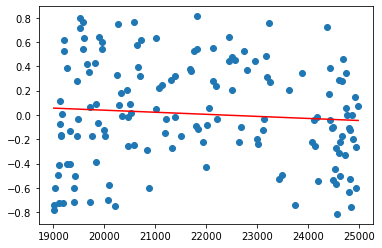

In [76]:
plt.scatter(df_masked.index.values,df_masked.values)
y_fit= -1.701e-05*df_masked.index.values+0.3792
plt.plot(df_masked.index.values,y_fit,c='red',label='regression trend')

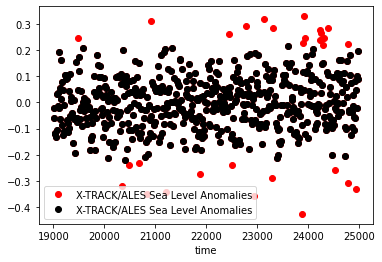

In [56]:
plot_point(ds,9)

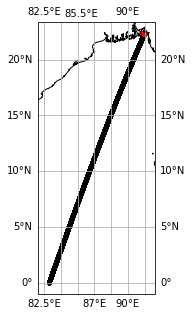

In [64]:
map_selected_point(ds,8502)